In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#rawdata=pd.read_csv('testset.csv')

In [ ]:
#data=rawdata.copy()

In [ ]:
#weather = data[['datetime_utc',' _tempm']]

In [ ]:
#weather = weather.rename(columns = {' _tempm':'temp','datetime_utc': 'datetime'})

In [ ]:
#weather['datetime']=pd.to_datetime(weather['datetime'])

In [ ]:
#weather['date']=weather['datetime'].dt.strftime('%Y-%m-%d')
#weather['time']=weather['datetime'].dt.strftime('%H')


In [ ]:
#weather.isnull().sum()

In [ ]:
#weather.drop('datetime',axis=1,inplace=True)

In [ ]:
#weather.dropna(inplace=True)


In [ ]:
#weather1 = weather.groupby(['date']).agg(AvgTemp = ('temp','mean')).round(0)

In [ ]:
#weather2 = weather.groupby('date')['temp'].mean().round(0).to_frame()

In [ ]:
#weather2.to_excel('kasweather.xlsx')

In [2]:
weather=pd.read_excel('kasweather.xlsx')

In [3]:
weather['date']=pd.to_datetime(weather['date'],format='%Y-%m-%d')

In [4]:
weather.dtypes

date    datetime64[ns]
temp             int64
dtype: object

In [ ]:
#weather['date']=weather['date'].dt.strftime('%Y-%m-%d')

TIME SERIES FORECASTING

In [ ]:
print("max temperature is :",weather['temp'].max())
print("min temperature is :",weather['temp'].min())

Check for stationarity

In [5]:
weather.set_index('date',inplace=True)

In [ ]:
weather.tail()

In [6]:
weather=weather.iloc[1383:]

In [ ]:
###weather.to_excel('weather2.xlsx')

In [9]:
weather_monthly = weather['temp'].resample('MS').first().round(1)

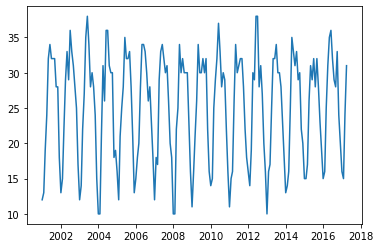

In [10]:
plt.plot(weather_monthly)

In [14]:
weather_monthly = pd.DataFrame(weather_monthly,columns = ['temp'])

In [ ]:
def roll_funct(dataf,win_p):
    from statsmodels.tsa.stattools import adfuller
    #Determine Rolling Statistics
    rollmean=dataf.rolling(window=win_p).mean()
    rollstd =dataf.rolling(window=win_p).std()
    #Plot RollingStatistics
    plt.figure(figsize=(30,8))
    orig= plt.plot(dataf, color = 'blue', label = 'original')
    mean = plt.plot(rollmean, color = 'red', label = 'RollMean')
    std = plt.plot(rollstd, color = 'black', label = 'RollStd')
    
    plt.legend(loc='best')
    plt.title('Rolling Statistics')
    plt.show(block=False)


In [ ]:
roll_funct(weather_monthly,12)

In [ ]:
from statsmodels.tsa.stattools import adfuller
    #Dickey-Fuller Test
    #print("Result for df-test is :")
    #dftest = adfuller(timeseries,autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index = ['Test Static','p-value','#LagUsed','Number of Observation Used'])
    #for key,value in dftest[4].items():
    #    dfoutput['Critical Value (%s)'%key]=value
    #print(dfoutput)   
def adftest(tseries):
    result =adfuller(tseries,autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Reject Null Hypothesis : Data is STATIONARY")
    else:
        print("Accept Null Hypothesis : Data is NON-STATIONARY")

In [ ]:
adftest(weather_monthly)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(weather_monthly,period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(60,16))
plt.subplot(4,1,1)
plt.plot(weather,label='Original')
plt.subplot(4,1,2)
plt.plot(trend,label='Trend')
plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonal')
plt.subplot(4,1,4)
plt.plot(residual,label='Residual')

In [11]:
weather_shift = weather_monthly-weather_monthly.shift(12)

In [ ]:
weather_shift = weather_shift.iloc[12:]

In [ ]:
adftest(weather_shift)

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(weather,nlags =15)
lag_pacf = pacf(weather, nlags =15, method='ols')

#plot acf
plt.subplot(1,2,1)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color = 'green')
plt.axhline(y = -1.96/np.sqrt(len(weather_shift)),linestyle = '--',color = 'grey')
plt.axhline(y = 1.96/np.sqrt(len(trend)),linestyle = '--',color = 'blue')
plt.title('Autocorrelation Feature')

plt.subplot(1,2,2,)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color = 'green')
plt.axhline(y = -1.96/np.sqrt(len(weather_shift)),linestyle = '--',color = 'grey')
plt.axhline(y = 1.96/np.sqrt(len(trend)),linestyle = '--',color = 'blue')

plt.title('Partial Autocorrelation Feature')

p=0,1 d=1, f=0,1

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal,lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal,lags=15,ax=ax2)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#SARIMAX Model
AR_Model = ARIMA(weather_monthly['temp'],order=(1, 0, 0),seasonal_order=(0,0,0,12))
result_arima = AR_Model.fit()
print(result_arima.summary())



In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [ ]:
p=d=q=range(0,2)

pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [ ]:
pdq

In [ ]:
for pdq_params in pdq:
    for seasonal_params in seasonal_pdq:
        try:
            model=SARIMAX(weather_monthly['temp'],
                          order=pdq_params,
                          seasonal_order=seasonal_params
                         )
            result=model.fit()
            print("SARIMAX({}x{})-AIC:{}".format(pdq_params,
                                                   seasonal_params,
                                                   result.aic
                                                  ))
            
        except:
            continue

In [15]:
SARIMA_Model = SARIMAX(weather_monthly['temp'],order=(1, 1, 1),seasonal_order=(0,1,1,12))
result_sarima = SARIMA_Model.fit()
print(result_sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  196
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -433.391
Date:                            Tue, 06 Sep 2022   AIC                            874.782
Time:                                    16:10:44   BIC                            887.620
Sample:                                01-01-2001   HQIC                           879.986
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0194      0.077      0.252      0.801      -0.131       0.170
ma.L1         -0.9404      0.043   

In [ ]:
weather_monthly['armiaforecast']=result_arima.predict(start=100,end=196,dynamic=True)

In [16]:
weather_monthly['sarimaforecast']=result_sarima.predict(start=105,end=220,dynamic=True)

<AxesSubplot:xlabel='date'>

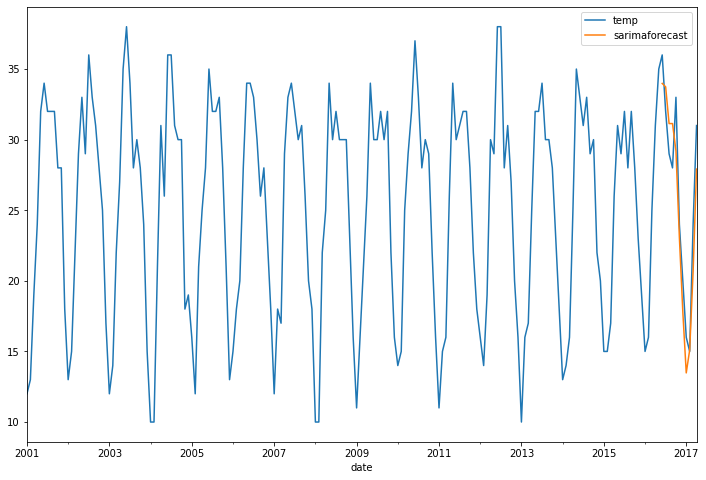

In [17]:
weather_monthly[['temp','sarimaforecast']].plot(figsize=(12,8))

In [18]:
from pandas.tseries.offsets import DateOffset
future_dates=[weather_monthly.index[-1]+ DateOffset(months=x)for x in range(0,104)]

In [19]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=weather_monthly.columns)

In [20]:
future_df=pd.concat([weather_monthly,future_datest_df])

In [21]:
future_df['sarimaforecast']= result_sarima.predict(start = 190,end = 220, dynamic=True)

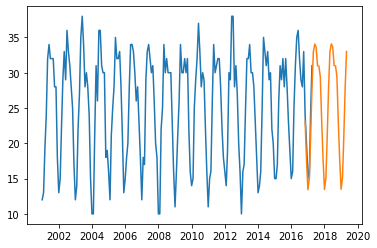

In [22]:
plt.plot(future_df)

NOW USING LSTM for timeseries